# Dimension and Information Loss

We measure dimensionality, information loss, and stability of nonlinear systems in various ways. 

TODO: 
1) Datasets: time series datasets (logistic map, chaotic attractors), image datasets (MNIST), manifold (swiss roll with extra dimensions)
2) Embedding algos: takens (TS), PCA, MLP-AE, CNN-AE, etc.
3) measure I(X,Y), reconstruciton loss (MSE/NMSE), loss in predictive power (f(x) vs. f(x_compressed)), etc. 

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import nbimporter
%run random_shannon_fcns.ipynb

In [268]:
# helper functions: 
def plot_delay(data, tau): 
    x = data[:-tau]  
    y = data[tau:]  
    
    plt.scatter(x, y, s=1, alpha=0.7)  
    plt.xlabel(f'x(t)')
    plt.ylabel(f'x(t+{tau})')
    plt.title(f'Delay Embedding (τ={tau})')
    plt.show()

# def L2_matrix(X):
#     X_norm = np.sum(X**2, axis=1, keepdims=True)
    
#     return np.sqrt(X_norm + X_norm.T - 2 * X @ X.T)

def L2_matrix(X):
    X = np.asarray(X, dtype=float)
    if X.ndim == 1:
        X = X[:, None]                      
    Xn = np.sum(X*X, axis=1)
    D2 = Xn[:, None] + Xn[None, :] - 2.0 * (X @ X.T)
    np.maximum(D2, 0, out=D2) 
    
    return np.sqrt(D2)
    
# good vlues for r: 0.1 * max(d(x_i, x_j)), 0.2 * stdev(X) where x_i is a delay vector 
# X in the def below is a 1d time series
def recurrence_mat(X, r, dim=2, delay=1):
    T = delay_embed(X, dim, delay)
    D = L2_matrix(T)

    R = (D < r).astype(int)

    return R

def plot_recurrence(X, r, dim, delay, title="Recurrence Plot"):
    R = recurrence_mat(X, r, dim=dim, delay=delay)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(R, cmap='binary', origin='lower')
    plt.title(title)
    plt.xlabel('Time i')
    plt.ylabel('Time j')
    plt.colorbar(label='Recurrence')
    plt.show()
    

def calculate_pca_loss_to_dim(X, pca, dim_min, dim_max): 
    pca_recon_loss_list = []
    for i in range(dim_min, dim_max+1): 
        loss, _, _ = pca_recon_loss(X, pca, i)
        pca_recon_loss_list.append(loss)

    return pca_recon_loss_list

def calculate_pca_feature_loss_to_dim(X, pca, dim_min, dim_max): 
    N = dim_max - dim_min + 1
    k = X.shape[1]
    feature_loss_mat = np.zeros((N, k))
    for i in range(N): 
        _, feature_loss, _ = pca_recon_loss(X, pca, i+dim_min)
        feature_loss_mat[i] = feature_loss

    return feature_loss_mat

def plot_pca_recon_loss(X, pca, dim_min, dim_max): 
    res = calculate_pca_loss_to_dim(X, pca, dim_min, dim_max)

    plt.title("PCA Reconstruction Loss (MSE) vs. Dimension")
    plt.xlabel("Dimension")
    plt.ylabel("MSE")
    plt.plot(np.arange(dim_min, dim_max+1), res, '.')
    plt.show()

### Forecasting algorithms

In [267]:
class TimeSeriesMLP(nn.Module): 
    def __init__(self): 
        super(TimeSeriesMLP, self).__init__()

        layer1 = MLP(lb, [16]*2, lb)

        self.fnn = layer1

    def forward(self, x): 
        x = self.fnn(x)
        return x

In [218]:
def logistic_map(r, x_0, max_iter = 1000): 
    traj = [x_0]

    for i in range(1, max_iter): 
        x = r * traj[i-1] * (1-traj[i-1])
        traj.append(x)

    return traj

def weierstrass(x, a, b, max_n): 
    res = np.zeros_like(x, dtype=float)
    for i in range(max_n): 
        res += a**i * np.cos(b**i * np.pi * x)
    return res

In [273]:
def mackey_glass_discrete(N=10000, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2):
    size = N + tau + 1
    x = np.empty(size, dtype=float)
    x[:tau+1] = float(x0) 

    for t in range(tau, size - 1):
        x_tau = x[t - tau]
        x[t + 1] = (1.0 - gamma) * x[t] + beta * x_tau / (1.0 + x_tau**n)

    return x[tau+1:]

## PCA on Time Series Data

### Logistic Map

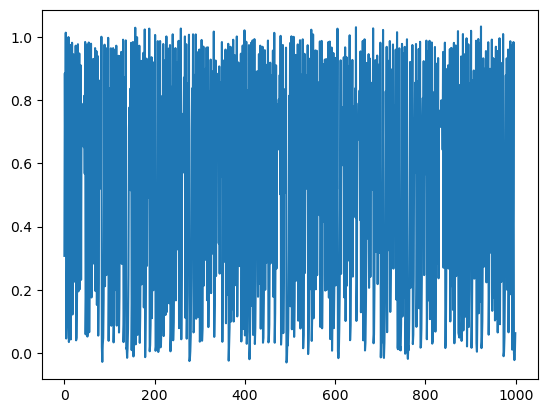

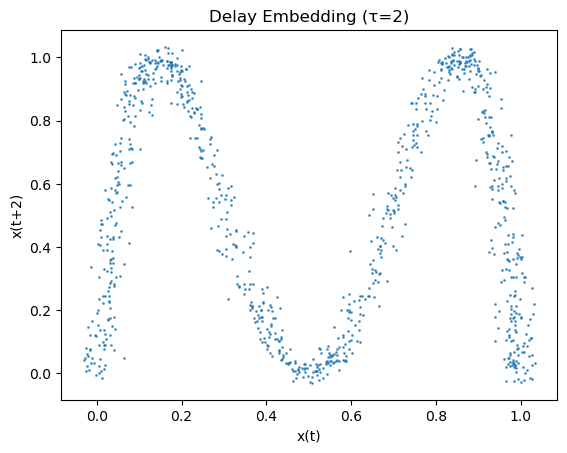

In [219]:
mu, sig = 0, 0.02
N = 1000
lgm = logistic_map(4.0, 0.3, N) + np.random.normal(mu, sig, N)

plt.plot(lgm)
plt.show()

plot_delay(lgm, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


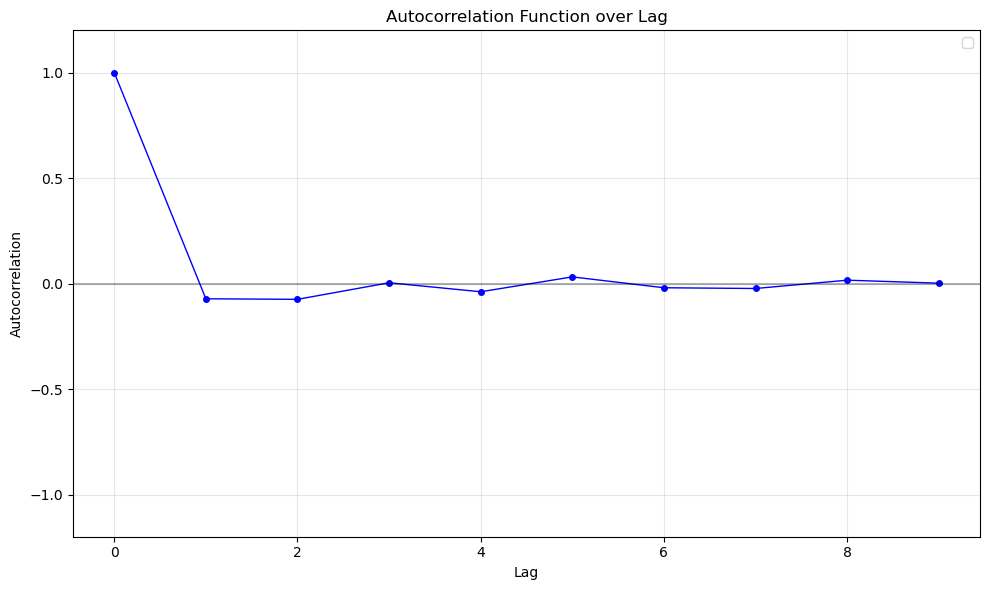

[1.0,
 -0.07233199427106721,
 -0.07490235735815633,
 0.0036276357952517227,
 -0.03906043107334726,
 0.03144203705139509,
 -0.02001541364213414,
 -0.023536933104375414,
 0.015863278311337294,
 0.0017031739930544593]

In [220]:
plot_acf(lgm, 10)

In [221]:
lgm_embedded.shape
r2_dim2.shape

(20,)

In [222]:
dim, delay = 20, 1
lgm_embedded = delay_embed(lgm, dim, delay)
lgm_delaypca, pca_lgm = delayPCA(lgm, dim, delay, dim)

lgm_pca_recon_loss = calculate_pca_loss_to_dim(lgm_embedded, pca_lgm, 2, dim)
lgm_pca_feature_loss = calculate_pca_feature_loss_to_dim(lgm_embedded, pca_lgm, 2, dim)

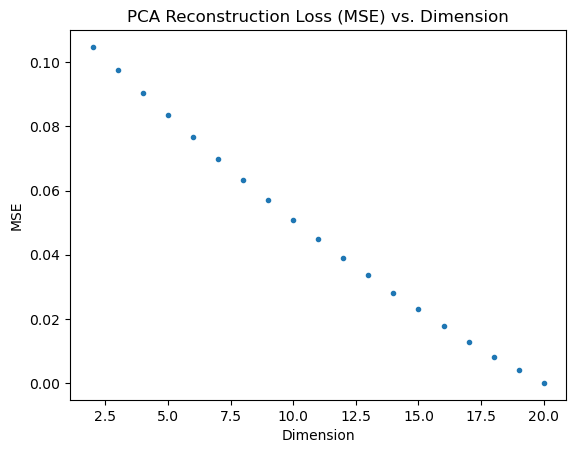

In [223]:
plot_pca_recon_loss(lgm_embedded, pca_lgm, 2, dim)

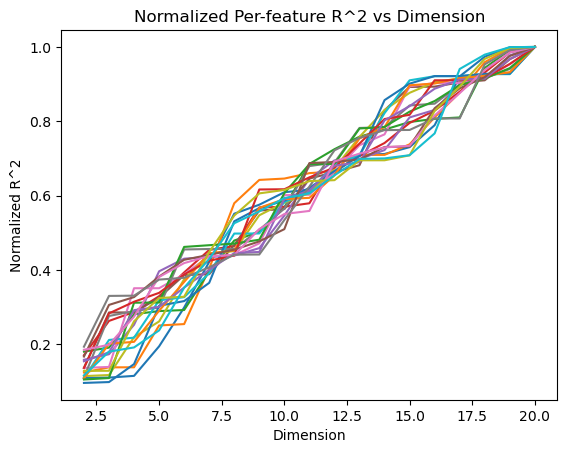

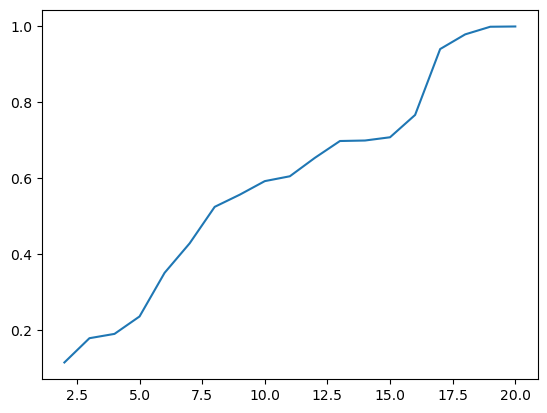

In [224]:
k_feat = 19

plt.title("Normalized Per-feature R^2 vs Dimension")
plt.plot(np.arange(2, dim+1), lgm_pca_feature_loss[:, :20])
plt.xlabel('Dimension')
plt.ylabel('Normalized R^2')
plt.show()

plt.title("")
plt.plot(np.arange(2, dim+1), lgm_pca_feature_loss[:, k_feat])
plt.show()

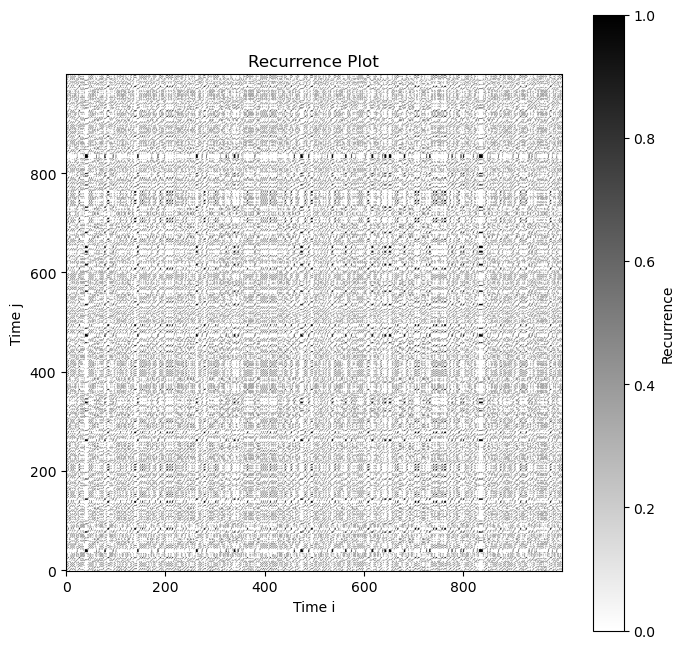

In [272]:
plot_recurrence(lgm, 0.5*np.std(lgm), 2, 1)

### Weierstrass Function 

In [258]:
ts_length = 10000
x_val = np.linspace(-2*np.pi, 4*np.pi, ts_length)
a = 0.87
b = 3.0
max_n = 100

wire = weierstrass(x_val, a, b, max_n) + np.random.normal(0, 0.1, ts_length)

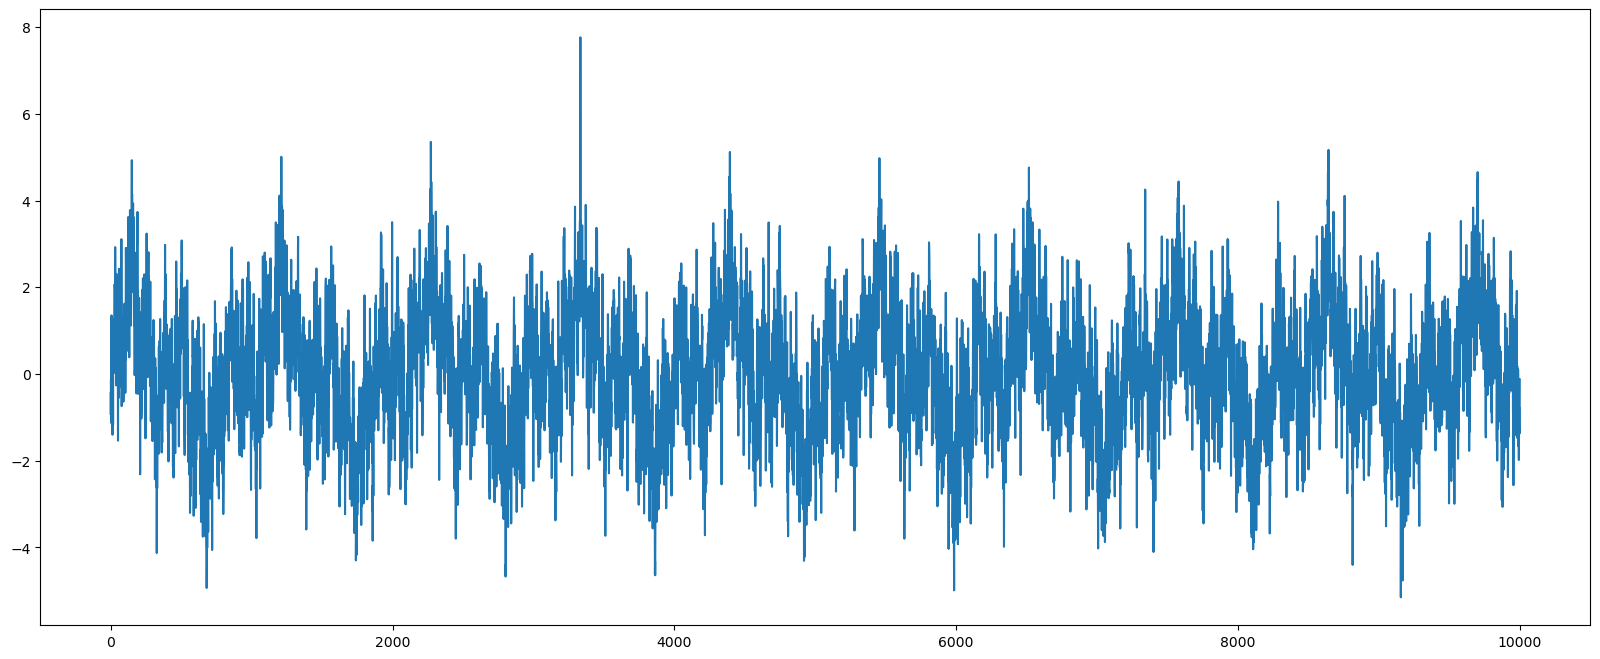

In [259]:
plt.figure(figsize=(20,8))
plt.plot(wire)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


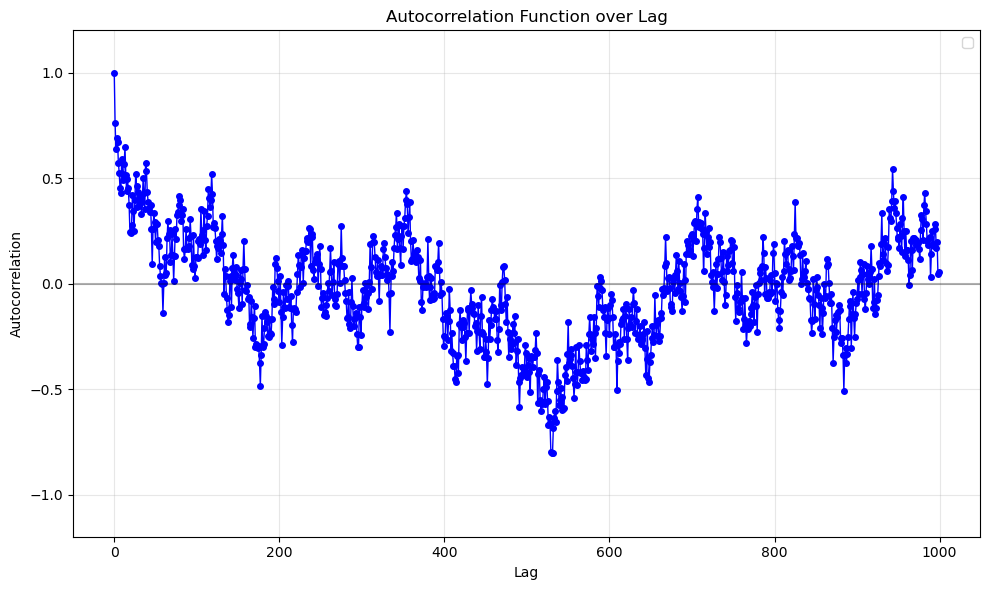

In [261]:
acf_wire = plot_acf(wire, 1000)

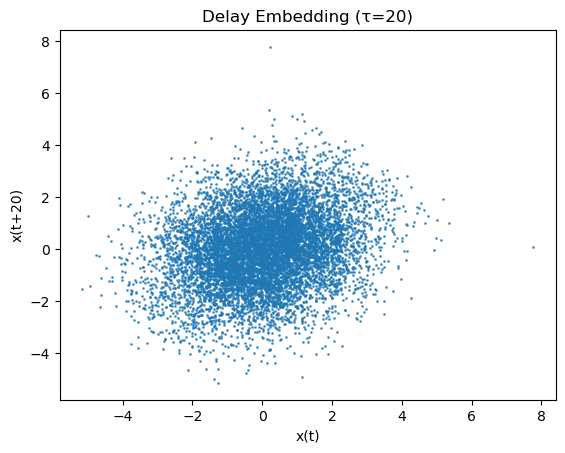

In [262]:
plot_delay(wire, 20)

/var/folders/k6/p59hn9vn3nl08dp9_ybv466c0000gn/T/ipykernel_58283/2389661599.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(X_norm + X_norm.T - 2 * X @ X.T)


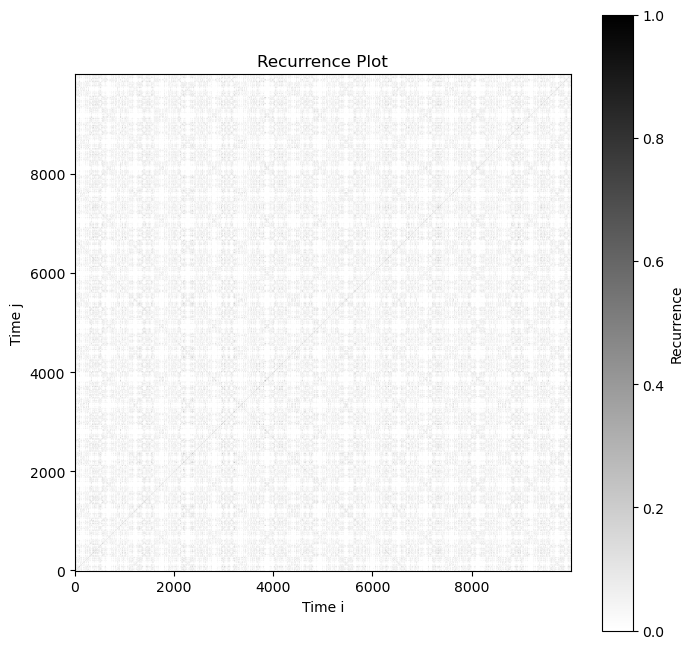

In [264]:
plot_recurrence(wire, 0.3*np.std(wire), 2, 1)

### Test cross recon loss; take a time series, split it into disjoint subsets, then carry out experiments 
### measures system stability